# Exploratory Data Analysis (EDA) Notebook for CS69.9/169.9 Team Project

**Acknowledgements** We acknowledge in advance for Kagglers' who shared their code publicly, numerous online documentations, blog posts, Q&A (e.g. StackOverflow), and dataset providers.

In [1]:
## Computer Vision modules:
import cv2 as cv
import tensorflow as tf

## ML/DL Modules:

## General utility modules:
import numpy as np 
import pandas as pd
from pathlib import Path
import os
import warnings

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
## Constants:
KAGGLE = False;
PREFIX = "/kaggle/" if KAGGLE else "../../";

DATA_DIR = Path(PREFIX+'input/imaterialist-fashion-2020-fgvc7/')
IMG_DIR = Path(PREFIX+'input/imaterialist-fashion-2020-fgvc7/train/')

## Load data:
df_train = pd.read_csv(DATA_DIR/'train.csv')
df_train.head()

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317"
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317"
2,00000663ed1ff0c4e0132b9b9ac53f6e,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,163
3,00000663ed1ff0c4e0132b9b9ac53f6e,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,"160,204"
4,00000663ed1ff0c4e0132b9b9ac53f6e,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,219


In [3]:
def summarize_columns(data, columns):
    """Creates data summary"""
    res = {}
    for col in columns:
        res[col] = data[col].describe()
    return pd.DataFrame(res)

summarize_columns(df_train, ["Height","Width"])

,Height,Width
count,333401.000000,333401.00000
mean,2235.524021,1761.97925
std,1543.320481,1425.54039
min,296.000000,151.00000
25%,1024.000000,720.00000
50%,1600.000000,1200.00000
75%,3000.000000,2275.00000
max,8688.000000,10717.00000


In [19]:
def show_size_distr(df, key="ImageId"):
    df_summ = df.groupby(key)["Height","Width"].first(); 
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11.69,8.27), dpi=100);
    ax1.hist(df['Height']);
    ax1.set_title("Height");
    ax1.set_ylabel("Count");
    
    ax2.hist(df['Width']);
    ax2.set_title("Width");
    
    plt.show(); 

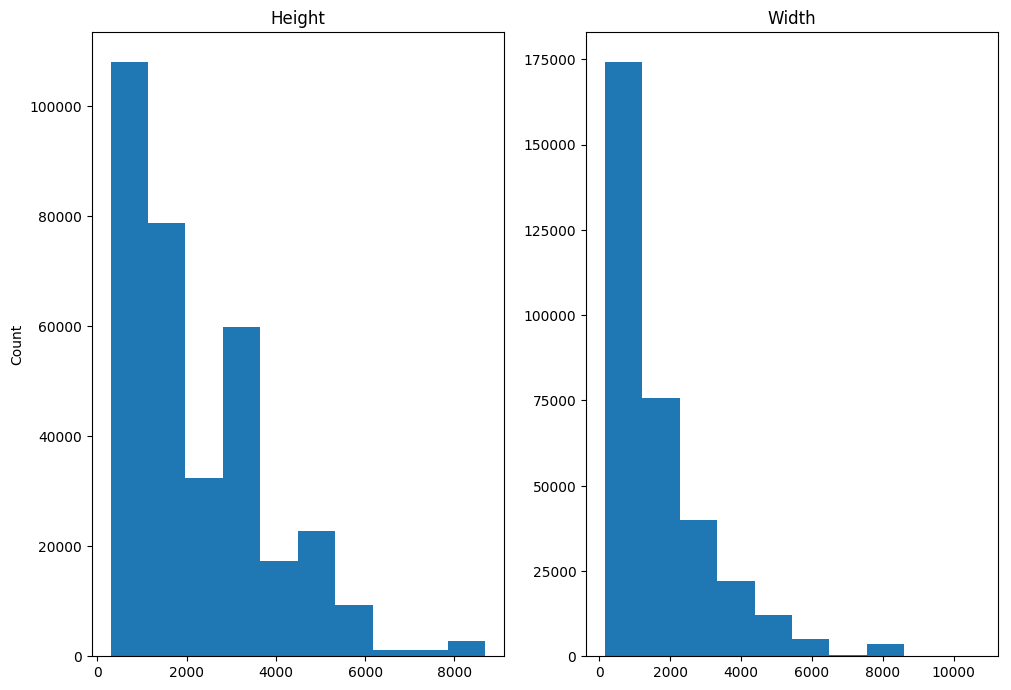

In [20]:
show_size_distr(df_train)

In [33]:
def get_random_img_ids(df, sample_size=4):
    """ Plot random images """
    image_ids = df["ImageId"].unique()
    return image_ids[np.random.choice(range(len(image_ids)), sample_size)]

def get_random_images(image_ids, seg_annot=None,
                      subdir="train/", basename=PREFIX+"input/imaterialist-fashion-2020-fgvc7/"):
    """
    Shows random images, either segmented or not
    :param image_ids: IDs for images to plot
    :param seg_annot: If provided, segmented images will be plotted. If None (default), original images will be returned
    :reference: Adapted from Shah K. on Kaggle
    """
    sample_size = len(image_ids)
    raw_images, masks, meta = [], [], [] #init.
    
    ## Load images & meta-data (ref.: Kaggle public notebook)
    for image_id in image_ids:
        image = mpimg.imread(basename+subdir+image_id+".jpg")
        raw_images.append(image)
        if seg_annot is not None:
            meta.append({
                "image": image,
                "shape": image.shape,
                "EncodedPixels": seg_annot[seg_annot["ImageId"] == image_id]["EncodedPixels"],
                "ClassId":  seg_annot[seg_annot["ImageId"] == image_id]["ClassId"]
            })
    
    if seg_annot is None: 
        return raw_images #early return
    
    ## Impose masks (ref.: Kaggle public notebook)
    del raw_images
    for image in meta:
        shape = image.get("shape")
        height, width = shape[ : 2]
        mask = np.zeros((height, width)).reshape(-1)
        
        encoded_pixels = list(image.get("EncodedPixels"))
        class_ids = list(image.get("ClassId"))
        
        for segment, (pixel_str,class_id) in enumerate(zip(encoded_pixels,class_ids)):
            splitted_pixels = list(map(int, pixel_str.split()))
            pixel_starts = splitted_pixels[::2]
            run_lengths = splitted_pixels[1::2]
            
            for pixel_start, run_length in zip(pixel_starts, run_lengths):
                pixel_start = int(pixel_start) - 1
                run_length = int(run_length)
                mask[pixel_start:pixel_start+run_length] = 255 - class_id * 4
        
        masks.append(mask.reshape((height, width), order="F"))
    
    return masks, meta

def plot_multipanel(images, isSegmented=False, num_groups=4, num_per_row=2):
    """
    Plots multi-panel images, either segmented or not
    :param isSegmented: If True, then the images object must be a tuple of length 2 with mask & metadata
    :reference: Adapted from Shah K. on Kaggle
    """
    if isSegmented:
        masks, meta = images
        assert(len(masks) == len(meta))
        sample_size = len(masks)
    else:
        sample_size = len(images)
        
    count = 0
    for index in range(sample_size // num_groups):
        fig, ax = plt.subplots(nrows=num_per_row, ncols=int(num_groups/num_per_row), figsize=(10,10), dpi=100)
        for row in ax:
            for col in row:
                if isSegmented:
                    col.imshow(meta[count]['image'])
                    col.imshow(masks[count], alpha=0.75)
                
                else:
                    col.imshow(images[count])
                
                col.axis('off')
                count += 1
        
        plt.show()

In [40]:
idx_sele = get_random_img_ids(df_train) #reusable
idx_sele

array(['c61627b52c63f44fee7e91510c45feb8',
       '3b4ef90c9dbd88f3cfb999220d4730c4',
       '69907bd7ff7e6d28d13e1357a0a15f60',
       '24ec05fdfc3cd2afe30a55d2bb628bfd'], dtype=object)

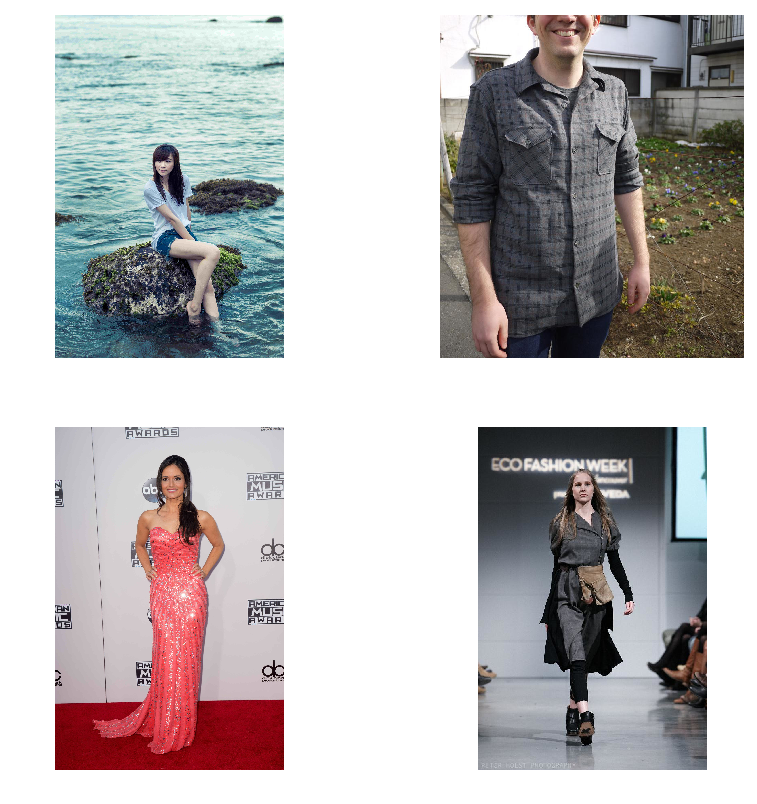

In [41]:
plot_multipanel(get_random_images(idx_sele, None))

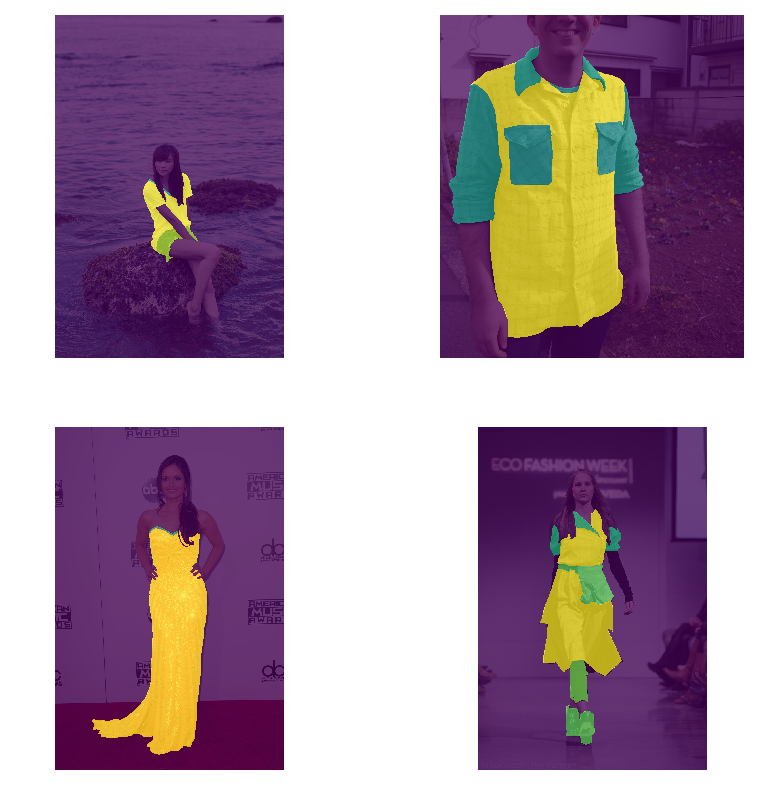

In [42]:
plot_multipanel(get_random_images(idx_sele, df_train), True)

In [60]:
from imgaug import augmenters as iaa
DATA_AUG = iaa.Sequential([
    ## Image rotation, translation, flipping:
    iaa.OneOf([
        iaa.Fliplr(0.2),
        iaa.Affine(
            scale = {"x": (0.99,1.01), "y":(0.98,1.03)},
            translate_percent = {"x": (-0.025,0.025), "y": (-0.05,0.05)},
            rotate = (-3, 3),
        ),
    ]),
    ## Adjustment of brightness, contrast norm, or resolution:
    iaa.OneOf([
        iaa.ContrastNormalization((0.75, 1.05)),
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
    ]),
]);

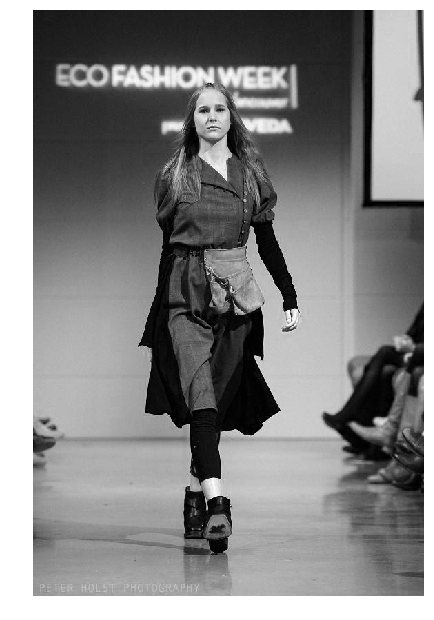

In [65]:
plt.figure(figsize=(int(30/4),12))
plt.axis('off')
plt.imshow(image[:,:,0], cmap="gray")

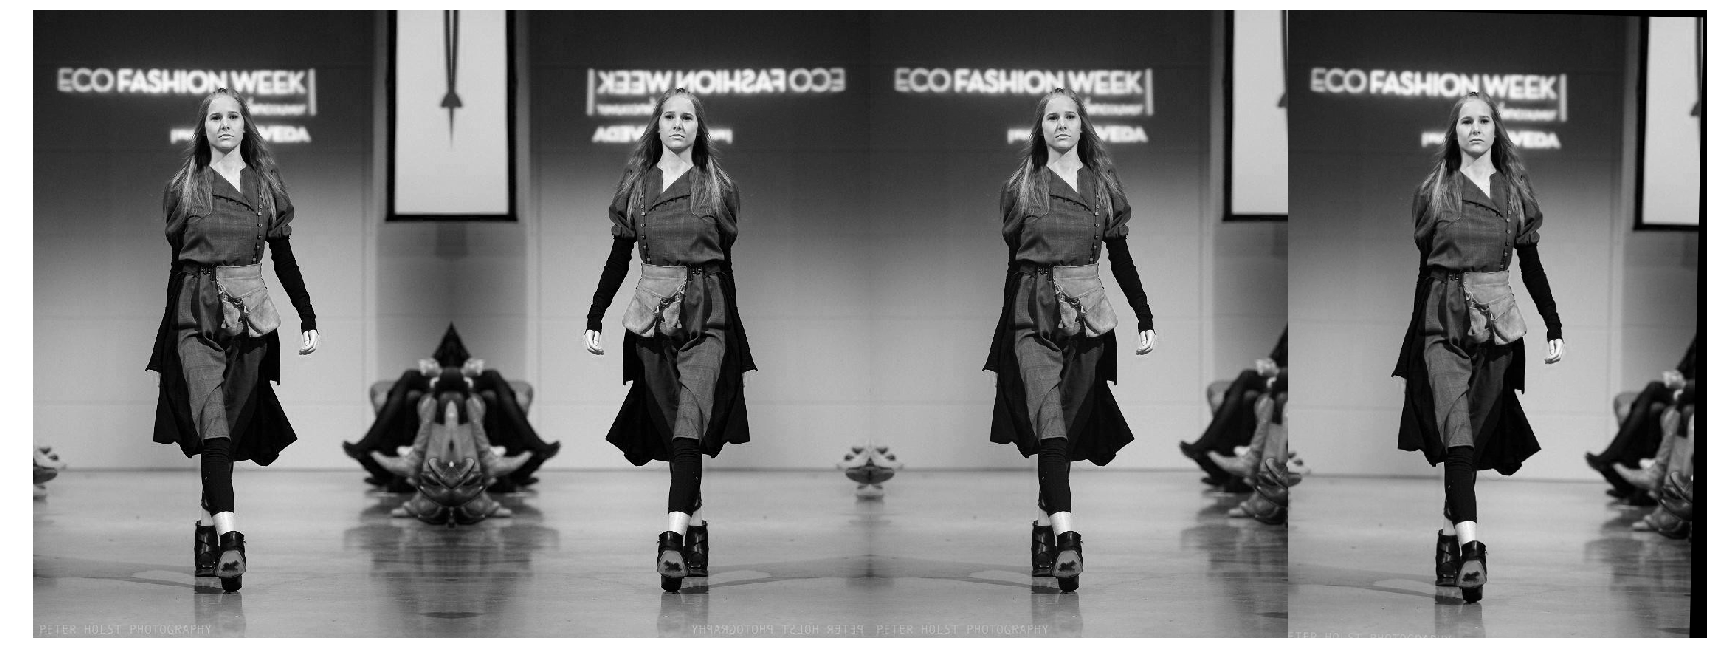

In [67]:
image = get_random_images([idx_sele[3]])[0]
imggrid = DATA_AUG.draw_grid(image[:,:,0], cols=4, rows=1)
plt.figure(figsize=(30,12))
plt.axis('off')
plt.imshow(imggrid[:,:,0], cmap="gray");